# Second order schemes for the multifactor CIR model

We start from a Volterra equation
$$X_t = x_0 + \int_0^t G(t-s) [a-k X_s] ds + \int_0^t G(t-s) \sigma \sqrt{X_s} dW_s$$
where $G(t)=\sum_{i=1}^n \gamma_i e^{- \rho_i t}$ with $0 \leq \rho_1 \leq ... \leq \rho_n$ and for all i $\in [1,n]$, $\gamma_i > 0$.

The solution of this equation is given by
$$X_t = x_0 + \sum_{i=1}^n \gamma_i X^i_t$$
where $x_i$ solves the SDE
$$d X_t^i = -\rho_i X_t^i dt + (a-kX_t)dt + \sigma \sqrt{X_t} dW_t \ \ \forall i \in [1,n]$$

The goal of this notebook is to implement a scheme to solve the system of equations above and deduce the solution of the Volterra. To do so, we use a splitting method. We can write the infinitesimal generator $\mathcal{L}$ of the system of equations above $\mathcal{L} = \mathcal{L}_1 + \mathcal{L}_2$, where $\mathcal{L}_1$ is the infinitesimal associated to
$$d X_t^t = - \rho_i X_t^t dt$$
and $\mathcal{L}_2$ is the infinitesimal generator associated to the SDE
$$d X_t^i = [a-kX_t^i] dt + \sigma \sqrt{X_t} dW_t, \ \ \text{with} \ \ X_t = x_0 + \sum_{i=1}^n \gamma_i X_t^i$$
It is easy to show that the solution of this equation can be written $X^i_t = x_i + \frac{\xi_t^x-x}{G(0)}$ where $\xi^x_t$ solves
$$d \xi^x_t = G(0) [a-kX_t] dt + G(0) \sigma \sqrt{X_t} dW_t, \ \ \xi_0^x = x$$ 
and we also have $X_t = \xi_t^x$ because 
\begin{align*}
X_t & = x_0 + \sum_{i=1}^n \gamma_i X^i_t \\
& = x_0 + \sum_{i=1}^n \gamma_i \left[ x_i + \frac{\xi^x_t - x}{G(0)} \right] \\
& = x_0 + \sum_{i=1}^n \gamma x_i + \frac{1}{G(0)} \left[ \sum_{i=1}^n \gamma_i \right] \left( \xi^x_t - x \right) \ \ \text{because} \ \ G(0)=\sum_{i=1}^n \gamma_i \\
X_t &= \xi^x_t \ \ \text{because} \ \ x=x_0+\sum_{i=1}^n \gamma_i x_i
\end{align*}

The first equation can be solved exactly and the solution if given by the scheme
$$\psi_1 ((x_1,...,x_n), t) = (x_1 e^{-\rho_1 t}, ..., x_n e^{-\rho_n t})$$

For the second equation on $\xi^x$, we test and compare different schemes $\psi_2$ :
- The Euler Scheme
- The scheme given by Alfonsi (see [the article](https://arxiv.org/pdf/2302.07758) for more details)
- The exact scheme. Indeed, we recall that the law of the increments of $\xi^x$ is decentered chi-square:
$$\xi_t^x = x + \int_0^t G(0) [a - k \xi^x_s] ds + \int_0^t G(0) \sigma \sqrt{\xi_s^x} dW_s$$

$$\xi^x_{t+\Delta t} \ | \ \xi^x_t \sim c \chi_d^2 (\lambda)$$
$$d = \frac{4\bar{a}}{\bar{k} \sigma^2}, \ \ \lambda = \frac{4\bar{k} \xi^x_t e^{-\bar{k} \Delta t}}{\sigma^2(1-e^{-\bar{k}\Delta t})}, \ \ c=\frac{\sigma^2(1-e^{-\bar{k}\Delta t})}{4\bar{k}}$$

The scheme we use to simulate the multifactor CIR model is 
$$\Psi (\textbf{x}, t, U) = \psi_1 (\psi_2 (\psi_1(\textbf{x}, t/2), t, U), t/2)$$
We implement a class to do simulations.

## Implementation of the class

In [1]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2  # decentered chi-square law
import time

In [2]:
class CIRProcess:
    """
    Cox-Ingersoll-Ross (CIR) multi-factor process.

    Parameters:
    -----------
    a : float
        Mean-reversion level parameter.
    k : float
        Mean-reversion speed parameter.
    sigma : float
        Volatility parameter.
    rho : float
        Decay rate for each factor.
    gamma : array-like of shape (dim,)
        Vector of weights for each factor.
    x0 : float
        Initial state value of the Volterra process.
    dim : int
        Number of factors in the multi-factor model.

    Note:
    -----
    This model can be used to represent various non-negative processes such as stochastic volatility, intensity processes, or other quantities exhibiting mean reversion and diffusion characteristics.
    """

    def __init__(self, a, k, sigma, rho, gamma, x0, dim):
        self.a = a
        self.k = k
        self.sigma = sigma
        self.rho = rho
        self.gamma = gamma
        self.x0 = x0
        self.G0 = sum(gamma)
        self.a_bar = a * self.G0
        self.k_bar = k * self.G0
        self.sigma_bar = sigma * self.G0
        self.dim = dim

    def zeta(self, t, k):
        return (1 - np.exp(-k * t)) / k if k != 0 else t

    def w(self, u):
        u = np.asarray(u)
        res = np.zeros_like(u)
        res[u > 5/6] = np.sqrt(3)
        res[u <= 1/6] = -np.sqrt(3)
        # values in between remain zero
        return res

    def u1(self, t, x):
        return x * np.exp(-self.k_bar * t) + self.a_bar * self.zeta(t, self.k_bar)

    def u2(self, t, x):
        term1 = self.u1(t, x)**2
        term2 = self.sigma_bar**2 * self.zeta(t, self.k_bar) * (
            self.a_bar * self.zeta(t, self.k_bar) / 2 + x * np.exp(-self.k_bar * t)
        )
        return term1 + term2

    def pi(self, t, x):
        res = 1 - self.u1(t, x)**2 / self.u2(t, x)
        return (1 - np.sqrt(res)) / 2

    def K2(self, t):
        if self.sigma_bar**2 > 4 * self.a_bar:
            term1 = (self.sigma_bar**2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            term2 = np.sqrt(
                np.exp(self.k_bar * t / 2) * (self.sigma_bar**2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            ) + self.sigma_bar * np.sqrt(3 * t) / 2
            return np.exp(self.k_bar * t / 2) * (term1 + term2**2)
        else:
            return 0

    def phi(self, x, t, u):
        x = np.asarray(x)
        u = np.asarray(u)
        K2_val = self.K2(t)

        res = np.zeros_like(x)

        mask_ge = (x >= K2_val)
        mask_lt = ~mask_ge

        # Case x >= K2_val
        if np.any(mask_ge):
            part1 = np.sqrt((self.a_bar - self.sigma_bar**2 / 4) * self.zeta(t / 2, self.k_bar) + np.exp(-self.k_bar * t / 2) * x[mask_ge])
            part1 += self.sigma_bar * np.sqrt(t) * self.w(u[mask_ge]) / 2
            part1 = np.exp(-self.k_bar * t / 2) * (part1 ** 2)
            part1 += (self.a_bar - self.sigma_bar**2 / 4) * self.zeta(t / 2, self.k_bar)
            res[mask_ge] = part1

        # Case x < K2_val
        if np.any(mask_lt):
            idx_lt = np.where(mask_lt)[0]
            x_lt = x[idx_lt]
            u_lt = u[idx_lt]
            p = self.pi(t, x_lt)
            mask_u_le_p = (u_lt <= p)

            # For u <= p
            if np.any(mask_u_le_p):
                idx_le = idx_lt[mask_u_le_p]
                res[idx_le] = self.u1(t, x[idx_le]) / (2 * p[mask_u_le_p])

            # For u > p
            if np.any(~mask_u_le_p):
                idx_gt = idx_lt[~mask_u_le_p]
                res[idx_gt] = self.u1(t, x[idx_gt]) / (2 * (1 - p[~mask_u_le_p]))

        return res

    def simulate_path(self, x0, T, N, n=1, seed=None):
        """
        Simulate paths using the phi transformation.

        Parameters:
        -----------
        x0 : float
            Initial state value.
        T : float
            Total simulation time.
        N : int
            Number of time steps.
        n : int, optional
            Number of paths to simulate (default is 1).
        seed : int or None, optional
            Random seed for reproducibility.

        Returns:
        --------
        ndarray
            Simulated paths of shape (n, N+1).
        """
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        for i in range(1, N + 1):
            u = np.random.uniform(size=n)
            paths[:, i] = self.phi(paths[:, i - 1], dt, u)

        return paths

    def simulate_path_euler(self, x0, T, N, n=1, seed=None):
        """
        Simulate paths using the Euler-Maruyama discretization scheme.

        Parameters:
        -----------
        x0 : float
            Initial state value.
        T : float
            Total simulation time.
        N : int
            Number of time steps.
        n : int, optional
            Number of paths to simulate (default is 1).
        seed : int or None, optional
            Random seed for reproducibility.

        Returns:
        --------
        ndarray
            Simulated paths of shape (n, N+1).
        """
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        for i in range(1, N + 1):
            xi = paths[:, i - 1]
            dW = np.sqrt(dt) * np.random.randn(n)

            drift = self.G0 * (self.a - self.k * xi)
            diffusion = self.G0 * self.sigma * np.sqrt(np.maximum(xi, 0))

            x_new = xi + drift * dt + diffusion * dW
            paths[:, i] = np.maximum(x_new, 0)

        return paths

    def simulate_path_exact(self, x0, T, N, n=1, seed=None):
        """
        Simulate paths exactly using the non-central chi-square distribution.

        Parameters:
        -----------
        x0 : float
            Initial state value.
        T : float
            Total simulation time.
        N : int
            Number of time steps.
        n : int, optional
            Number of paths to simulate (default is 1).
        seed : int or None, optional
            Random seed for reproducibility.

        Returns:
        --------
        ndarray
            Simulated paths of shape (n, N+1).
        """
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        paths = np.zeros((n, N + 1))
        paths[:, 0] = x0

        d = 4 * self.k_bar * (self.a_bar / self.k) / (self.sigma_bar ** 2)  # degrees of freedom

        for i in range(1, N + 1):
            c = (self.sigma_bar ** 2 * (1 - np.exp(-self.k_bar * dt))) / (4 * self.k_bar)
            nc = (4 * self.k_bar * np.exp(-self.k_bar * dt) * paths[:, i - 1]) / (self.sigma_bar ** 2 * (1 - np.exp(-self.k_bar * dt)))
            paths[:, i] = c * ncx2.rvs(d, nc, size=n)

        return paths

    def A(self, X, y, x0):
        x = x0 + np.dot(X, self.gamma)  # scalar projection of factors
        return X + ((y - x) / self.G0)[:, np.newaxis]

    def psi2(self, X, t, u, x0):
        x = x0 + np.dot(X, self.gamma)
        y = self.phi(x, t, u)
        return self.A(X, y, x0)

    def psi1(self, X, t):
        return X * np.exp(-self.rho * t)

    def psi(self, X, t, Z, x0):
        res = self.psi1(X, t / 2)
        res2 = self.psi2(res, t, Z, x0)
        return self.psi1(res2, t / 2)

    def simulate_multifactor(self, T, N, n_simulation=1, seed=None):
        """
        Simulate multi-factor paths using the psi scheme.

        Parameters:
        -----------
        x0 : float
            Initial scalar state.
        T : float
            Total simulation time.
        N : int
            Number of time steps.
        n_simulation : int, optional
            Number of simulation paths (default is 1).
        seed : int or None, optional
            Random seed for reproducibility.

        Returns:
        --------
        ndarray
            Simulated multi-factor paths of shape (n_simulation, N+1, dim).
        """
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        path = np.zeros((n_simulation, N + 1, self.dim))
        path[:, 0, :] = 0

        for i in range(1, N + 1):
            Z = np.random.uniform(size=n_simulation)
            path[:, i, :] = self.psi(path[:, i - 1, :], dt, Z, self.x0)

        return path

    def simulate_multifactor_euler(self, N, T, num_simulations=1, seed=None):
        """
        Simulate multi-factor paths using Euler-Maruyama discretization.

        Parameters:
        -----------
        N : int
            Number of time steps.
        T : float
            Total simulation time.
        num_simulations : int, optional
            Number of simulation paths (default is 1).
        seed : int or None, optional
            Random seed for reproducibility.

        Returns:
        --------
        ndarray
            Simulated multi-factor paths of shape (N, num_simulations, dim).
        """
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        Y = np.zeros((N, num_simulations, self.dim))
        Y[0] = 0
        ones = np.ones((num_simulations, self.dim))

        for i in range(1, N):
            Y_prev = Y[i - 1]

            w_dot_Y = np.dot(Y_prev, self.gamma)

            drift = - Y_prev * self.rho

            global_drift = (self.a - self.k * w_dot_Y).reshape(-1, 1) * ones

            sigma_vals = self.sigma * np.sqrt(np.maximum(w_dot_Y, 0)).reshape(-1, 1)
            noise = sigma_vals * np.sqrt(dt) * np.random.randn(num_simulations, 1) * ones

            Y[i] = Y_prev + dt * drift + dt * global_drift + noise

        return Y

    def phi_zc(self, t):
        gamma = np.sqrt(self.k_bar**2 + 2*self.sigma_bar**2)
        res = (2*gamma*np.exp(t*(gamma+self.k_bar)/2)) / (gamma-self.k_bar + np.exp(gamma*t) * (gamma + self.k_bar))
        return (-2/self.sigma_bar**2) * np.log(res)

    def psi_zc(self, t):
        gamma = np.sqrt(self.k_bar**2 + 2*self.sigma_bar**2)
        return 2 * (np.exp(gamma*t) - 1) / (gamma-self.k_bar+np.exp(gamma*t) * (gamma + self.k_bar))

    def zero_coupon_price_closed_form(self, T):
        """
        Compute the closed-form price of a zero-coupon instrument at time T.

        Parameters:
        -----------
        T : float
            Time to maturity.

        Returns:
        --------
        float
            Zero-coupon price at time T.
        """
        return np.exp(-self.a_bar * self.phi_zc(T) - self.x0 * self.psi_zc(T))




## Simulations of the CIR process

We simulate the CIR process $\xi^x_t$ for the three schemes.

G0 * sigma^2 = 0.011200000000000003
4 * a = 0.2


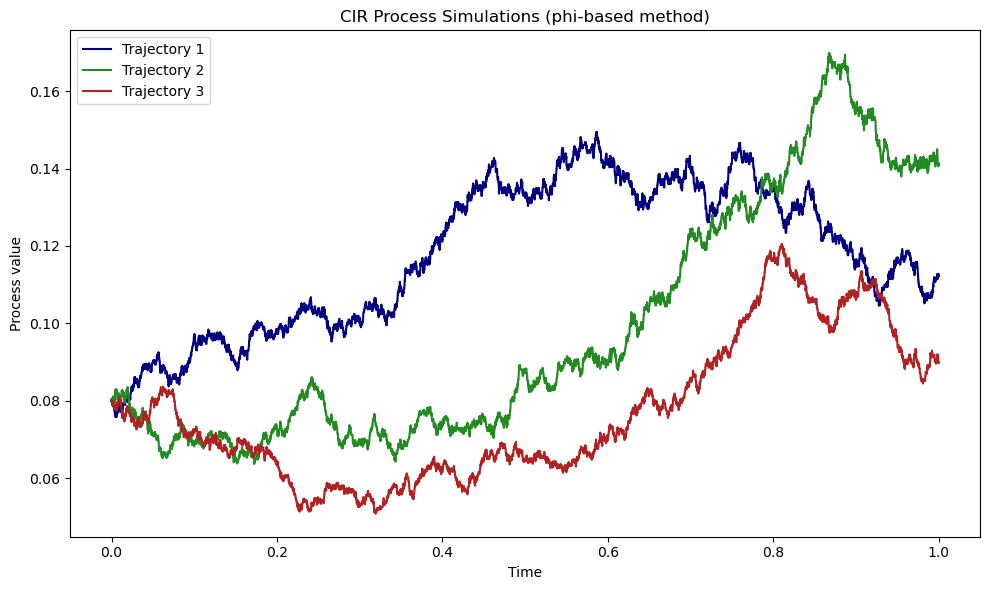

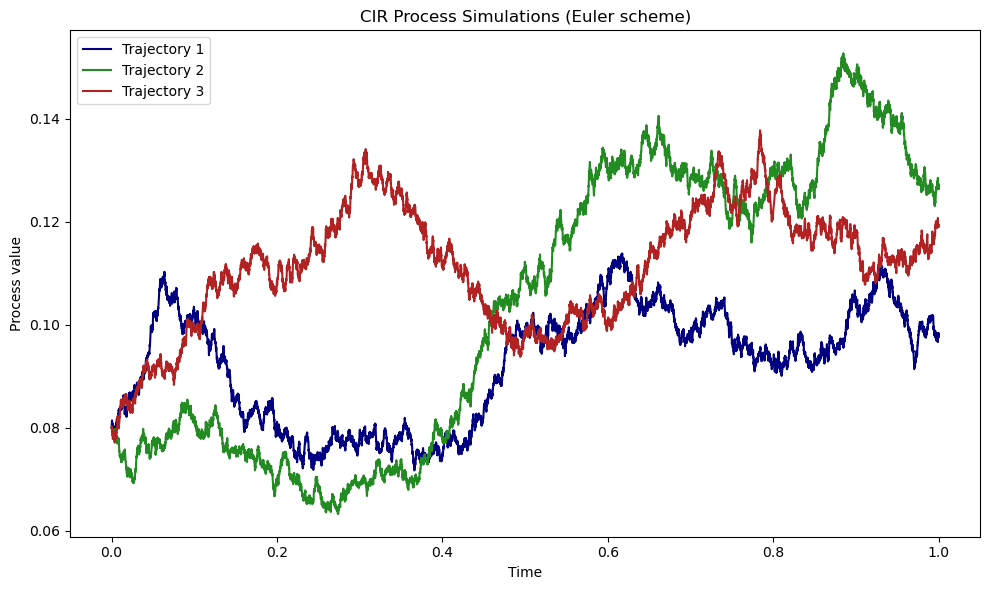

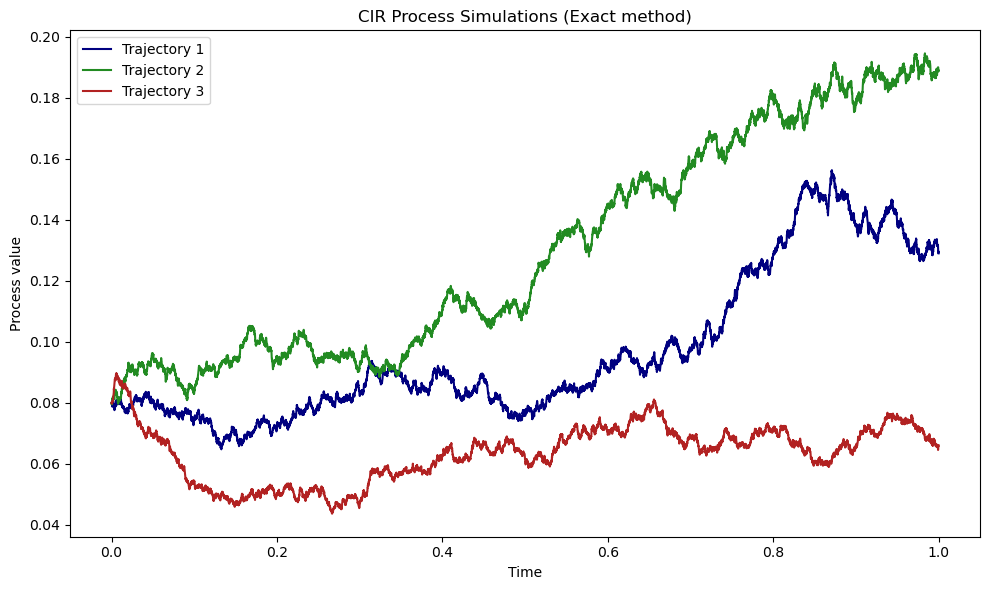

In [3]:
# Parameters for the simulations
a = 0.05
k = 0.15
sigma = 0.1
x0 = 0.08
T = 1
N = 10000

rho = np.array([0.06, 1.05, 1.79, 2.52, 3.25])
gamma = np.array([0.96, 0.07, 0.04, 0.03, 0.02])

print("G0 * sigma^2 =", sum(gamma) * sigma**2)
print("4 * a =", 4 * a)

# CIR process instantiation
cir = CIRProcess(a, k, sigma, rho, gamma, 0, len(rho))

n_trajectories = 3
times = np.linspace(0, T, N + 1)

# Simulation using phi-based method
paths = cir.simulate_path(x0, T, N, n=n_trajectories, seed=42)
colors = ['navy', 'forestgreen', 'firebrick']

plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths[i], label=f'Trajectory {i+1}', color=colors[i])
plt.title("CIR Process Simulations (phi-based method)")
plt.xlabel("Time")
plt.ylabel("Process value")
plt.legend()
plt.tight_layout()
plt.show()

# Simulation using Euler-Maruyama scheme
paths_euler = cir.simulate_path_euler(x0, T, N, n=n_trajectories, seed=42)
plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths_euler[i], label=f'Trajectory {i+1}', color=colors[i])
plt.title("CIR Process Simulations (Euler scheme)")
plt.xlabel("Time")
plt.ylabel("Process value")
plt.legend()
plt.tight_layout()
plt.show()

# Simulation using exact scheme (noncentral chi-squared)
paths_exact = cir.simulate_path_exact(x0, T, N, n=n_trajectories, seed=42)
plt.figure(figsize=(10, 6))
for i in range(n_trajectories):
    plt.plot(times, paths_exact[i], label=f'Trajectory {i+1}', color=colors[i])
plt.title("CIR Process Simulations (Exact method)")
plt.xlabel("Time")
plt.ylabel("Process value")
plt.legend()
plt.tight_layout()
plt.show()



We simulate a great number of paths thanks to the three schemes and we plot the empirical distribution of $\xi_T^x$ for each scheme.

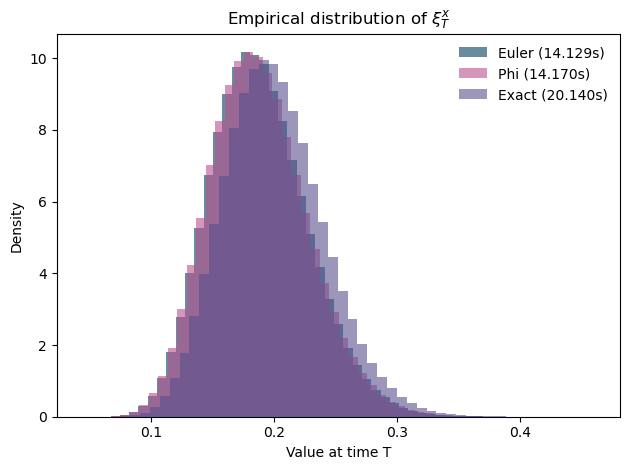

In [4]:
# Parameters
x0 = 0.1
T = 1.0
N = 100
n_paths = 10**6

cir = CIRProcess(a=0.1, k=0.15, sigma=0.1, rho=rho, gamma=gamma, x0=0, dim=len(rho))

# Euler simulation
start = time.time()
paths_euler = cir.simulate_path_euler(x0, T, N, n=n_paths, seed=42)
time_euler = time.time() - start

# Phi-based simulation
start = time.time()
paths_phi = cir.simulate_path(x0, T, N, n=n_paths, seed=42)
time_phi = time.time() - start

# Exact simulation
start = time.time()
paths_exact = cir.simulate_path_exact(x0, T, N, n=n_paths, seed=42)
time_exact = time.time() - start

# Mean at final time T
mean_euler = np.mean(paths_euler[:, -1])
mean_phi = np.mean(paths_phi[:, -1])
mean_exact = np.mean(paths_exact[:, -1])

# Variance at final time T
var_euler = np.var(paths_euler[:, -1])
var_phi = np.var(paths_phi[:, -1])
var_exact = np.var(paths_exact[:, -1])

# Histogram comparison of the final values for each method
plt.hist(paths_euler[:, -1], bins=50, alpha=0.6, color='#003f5c',
         label=f'Euler ({time_euler:.3f}s)', density=True)
plt.hist(paths_phi[:, -1], bins=50, alpha=0.6, color='#bc5090',
         label=f'Phi ({time_phi:.3f}s)', density=True)
plt.hist(paths_exact[:, -1], bins=50, alpha=0.6, color='#58508d',
         label=f'Exact ({time_exact:.3f}s)', density=True)

plt.legend(frameon=False)
plt.xlabel('Value at time T')
plt.ylabel('Density')
plt.title(r'Empirical distribution of $\xi_T^x$')
plt.tight_layout()
plt.show()


We plot the computation time to simulate a great number of paths vs the time step $\Delta t$.

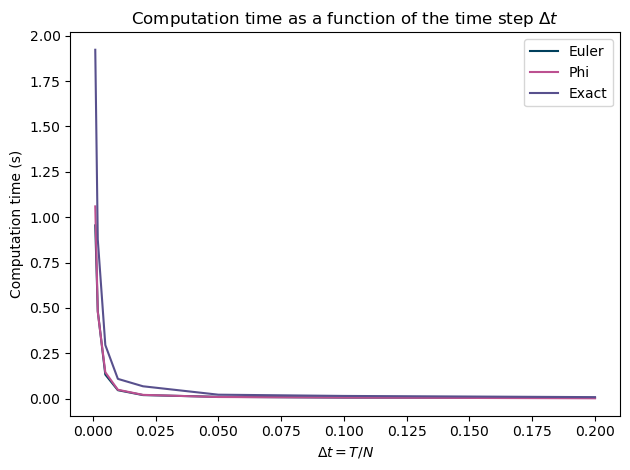

In [5]:
# Parameters
x0 = 0.1
T = 1.0
n_paths = 10000
N_list = [5, 10, 20, 50, 100, 200, 500, 1000]

delta_t_list = []
times_euler = []
times_phi = []
times_exact = []

# Initialize CIR process
cir = CIRProcess(a=0.1, k=0.15, sigma=0.1, rho=rho, gamma=gamma, x0=x0, dim=len(rho))

# Run simulations
for N in N_list:
    delta_t = T / N
    delta_t_list.append(delta_t)

    start = time.time()
    cir.simulate_path_euler(x0, T, N, n=n_paths)
    times_euler.append(time.time() - start)

    start = time.time()
    cir.simulate_path(x0, T, N, n=n_paths)
    times_phi.append(time.time() - start)

    start = time.time()
    cir.simulate_path_exact(x0, T, N, n=n_paths)
    times_exact.append(time.time() - start)

# Plotting (lignes seulement)
plt.plot(delta_t_list, times_euler, label='Euler', color='#003f5c')
plt.plot(delta_t_list, times_phi, label='Phi', color='#bc5090')
plt.plot(delta_t_list, times_exact, label='Exact', color='#58508d')

plt.xlabel(r'$\Delta t = T / N$')
plt.ylabel('Computation time (s)')
plt.title(r'Computation time as a function of the time step $\Delta t$')
plt.legend()
plt.tight_layout()
plt.show()



## Price of the zero-coupon bond

We compute the price of the zero-coupon bond by Monte-Carlo method using the three schemes. We compare these prices to the real price $P(0,T)$, which admits a closed formula in the CIR model.

In [ ]:
def zero_coupon_price_MC(paths, dt):
    """
    Compute the zero-coupon price by Monte Carlo estimation
    from simulated paths of the process.

    Parameters:
        paths: array-like, shape (n_paths, n_steps+1)
            Simulated trajectories of the process.
        dt: float
            Time step size.

    Returns:
        tuple: (mean_price, std_price)
            Estimated zero-coupon price P(0,T) and its standard deviation.
    """
    # Approximate the integral over [0,T] for each path using trapezoidal rule
    integral = dt * ((paths[:, 0] + paths[:, -1]) / 2 + np.sum(paths[:, 1:-1], axis=1))
    discounts = np.exp(-integral)

    mean_price = np.mean(discounts)
    std_price = np.std(discounts, ddof=1)  # unbiased estimator with ddof=1

    return mean_price, std_price

# Parameters
a, k, sigma, rho, gamma = 0.5, 0.7, 0.5, [0], [1]
x0 = 0.4
T = 1
N = 100
n = 10**4
dt = T / N

cir = CIRProcess(a, k, sigma, rho, gamma, x0, 1)

# Exact simulation
start = time.time()
paths_exact = cir.simulate_path_exact(x0, T, N, n)
P_exact, std_exact = zero_coupon_price_MC(paths_exact, dt)
time_exact = time.time() - start

# Phi simulation
start = time.time()
paths_phi = cir.simulate_path(x0, T, N, n)
P_phi, std_phi = zero_coupon_price_MC(paths_phi, dt)
time_phi = time.time() - start

# Euler simulation
start = time.time()
paths_euler = cir.simulate_path_euler(x0, T, N, n)
P_euler, std_euler = zero_coupon_price_MC(paths_euler, dt)
time_euler = time.time() - start

# Closed-form solution
P_closed = cir.zero_coupon_price_closed_form(T)

# Display results with standard deviations
print(f"Zero-coupon price P(0,T={T}) by Exact method : {P_exact:.6f} ± {std_exact / np.sqrt(n):.6f} (in {time_exact:.2f} s)")
print(f"Zero-coupon price P(0,T={T}) by Phi method   : {P_phi:.6f} ± {std_phi / np.sqrt(n):.6f} (in {time_phi:.2f} s)")
print(f"Zero-coupon price P(0,T={T}) by Euler method : {P_euler:.6f} ± {std_euler / np.sqrt(n):.6f} (in {time_euler:.2f} s)")
print(f"Zero-coupon price P(0,T={T}) by closed-form formula : {P_closed:.6f}")

Zero-coupon price P(0,T=1) by Exact method : 0.620809 ± 0.000893 (in 0.15 s)
Zero-coupon price P(0,T=1) by Phi method   : 0.619742 ± 0.000895 (in 0.06 s)
Zero-coupon price P(0,T=1) by Euler method : 0.620978 ± 0.000899 (in 0.05 s)
Zero-coupon price P(0,T=1) by closed-form formula : 0.620568


We plot the time to compute zero-coupon bond price vs time step

In [ ]:
# Fixed parameters
x0 = 0.4
T = 1.0
n = 10**6

a, k, sigma, rho, gamma = 0.5, 0.7, 0.3, 0, [1]
cir = CIRProcess(a, k, sigma, rho, gamma, x0, 1)

N_values = [5, 7, 10, 15, 20, 100, 200]

# Containers for means and stds
price_exact_list = []
price_phi_list = []
price_euler_list = []

std_exact_list = []
std_phi_list = []
std_euler_list = []

time_exact_list = []
time_phi_list = []
time_euler_list = []

dt_values = []

# Number of MC paths as float for calculations
n_float = float(n)

for N in N_values:
    dt = T / N
    dt_values.append(dt)

    # Exact simulation
    start = time.time()
    paths_exact = cir.simulate_path_exact(x0, T, N, n)
    # Compute integral per path for MC price and std
    integral_exact = dt * ((paths_exact[:, 0] + paths_exact[:, -1]) / 2 + np.sum(paths_exact[:,1:-1], axis=1))
    price_exact = np.mean(np.exp(-integral_exact))
    std_exact = np.std(np.exp(-integral_exact))
    time_exact = time.time() - start

    price_exact_list.append(price_exact)
    std_exact_list.append(std_exact)
    time_exact_list.append(time_exact)

    # Phi simulation
    start = time.time()
    paths_phi = cir.simulate_path(x0, T, N, n)
    integral_phi = dt * ((paths_phi[:, 0] + paths_phi[:, -1]) / 2 + np.sum(paths_phi[:,1:-1], axis=1))
    price_phi = np.mean(np.exp(-integral_phi))
    std_phi = np.std(np.exp(-integral_phi))
    time_phi = time.time() - start

    price_phi_list.append(price_phi)
    std_phi_list.append(std_phi)
    time_phi_list.append(time_phi)

    # Euler simulation
    start = time.time()
    paths_euler = cir.simulate_path_euler(x0, T, N, n)
    integral_euler = dt * ((paths_euler[:, 0] + paths_euler[:, -1]) / 2 + np.sum(paths_euler[:,1:-1], axis=1))
    price_euler = np.mean(np.exp(-integral_euler))
    std_euler = np.std(np.exp(-integral_euler))
    time_euler = time.time() - start

    price_euler_list.append(price_euler)
    std_euler_list.append(std_euler)
    time_euler_list.append(time_euler)

# Convert lists to numpy arrays for convenience
price_exact_arr = np.array(price_exact_list)
price_phi_arr = np.array(price_phi_list)
price_euler_arr = np.array(price_euler_list)

std_exact_arr = np.array(std_exact_list)
std_phi_arr = np.array(std_phi_list)
std_euler_arr = np.array(std_euler_list)

price_closed_form = cir.zero_coupon_price_closed_form(T)

ci = 1.96  # for 95% confidence interval

# Plot zero-coupon prices with vertical error bars (95% CI)
plt.figure(figsize=(10, 5))

plt.errorbar(dt_values, price_exact_arr,
             yerr=ci * std_exact_arr / np.sqrt(n_float),
             label='Exact', color='#1f4e79', linestyle='-', capsize=0)

plt.errorbar(dt_values, price_phi_arr,
             yerr=ci * std_phi_arr / np.sqrt(n_float),
             label='Phi', color='#9b2d30', linestyle='-', capsize=0)

plt.errorbar(dt_values, price_euler_arr,
             yerr=ci * std_euler_arr / np.sqrt(n_float),
             label='Euler', color='#807f7f', linestyle='-', capsize=0)

plt.axhline(price_closed_form, color='#3a6ea5', linestyle='--', label='Closed-form')

plt.xlabel('Time step size $\\Delta t = T/N$')
plt.ylabel('Zero-Coupon Price $P(0,T)$')
plt.title('Zero-Coupon Bond Price $P(0,T)$ with 95% Confidence Intervals')
plt.legend()
plt.show()


# Plot computation times (no error bars, just lines)
plt.figure(figsize=(10, 5))
plt.plot(dt_values, time_exact_list, label='Exact', color='#1f4e79')
plt.plot(dt_values, time_phi_list, label='Phi', color='#9b2d30')
plt.plot(dt_values, time_euler_list, label='Euler', color='#807f7f')
plt.xlabel('Time step size $\\Delta t = T/N$')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time vs. Time Step Size $\\Delta t$')
plt.legend()
plt.show()


## Simulation of the multifactor CIR process

We do the implementation in dimension $2$.

G0 * sigma^2 = 0.27
4 * a = 0.08


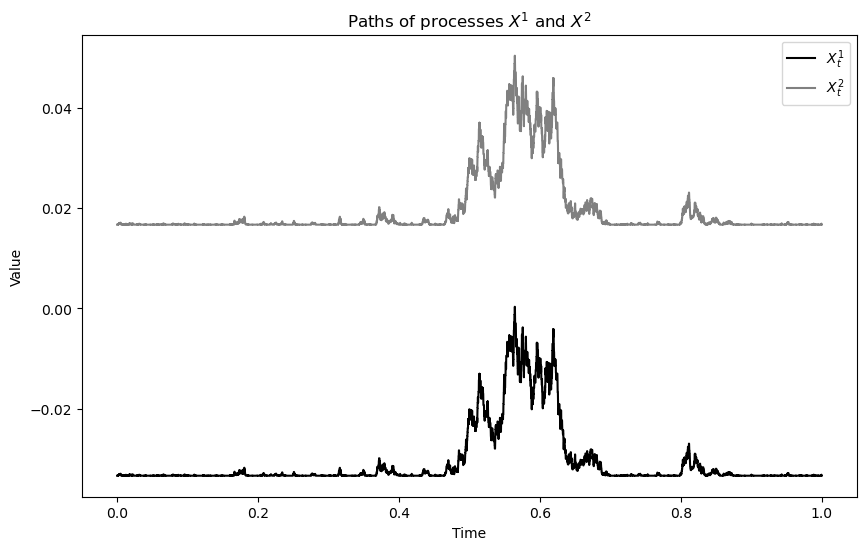

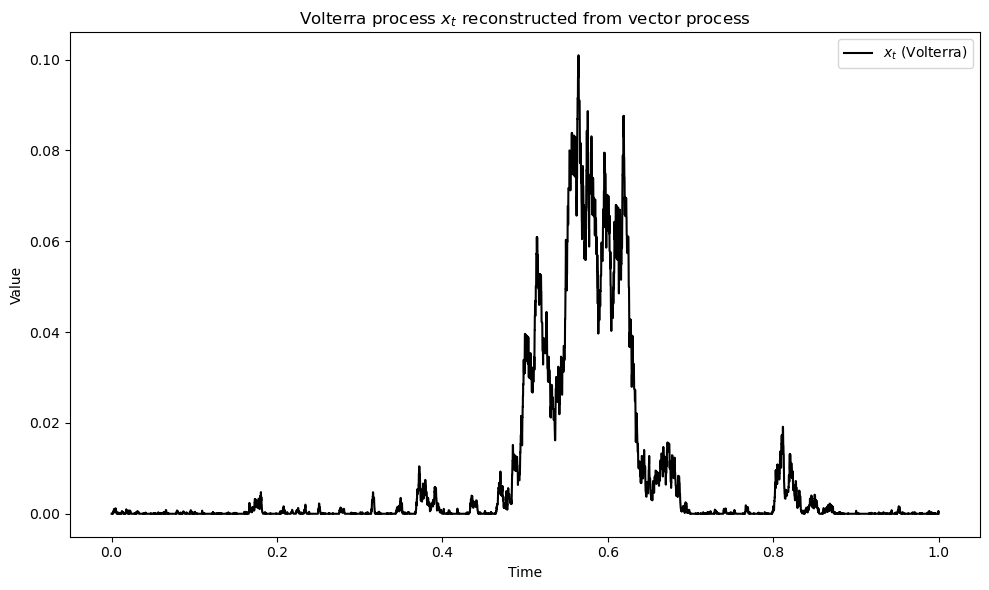

In [8]:
# Model parameters
a = 0.02
k = 0.3
sigma = 0.3
x0 = 0.0
T = 1
N = 10000

rho = np.array([1, 10])
gamma = np.array([1, 2])
dim = len(rho)

# Initial conditions for the vector process
X0 = np.array([0.05, 0.1])
x = x0 + np.dot(gamma, X0)  # x = x0 + gamma^T * X0

# Verification output
print("G0 * sigma^2 =", sum(gamma) * sigma**2)
print("4 * a =", 4 * a)

# Instantiate CIR model
cir = CIRProcess(a, k, sigma, rho, gamma, x, dim)

# Simulate scalar path x(t) using the phi scheme
x_path = cir.simulate_path(x0, T, N, n=1)[0]  # shape: (N+1,)

# Vectorized calculation of A(x_t) from X0 and x(t)
G0 = cir.G0
x_t = x_path  # shape: (N+1,)
x_bar = x0 + np.dot(X0, gamma)  # scalar
A_path = X0 + ((x_t - x_bar) / G0)[:, np.newaxis]  # shape: (N+1, dim)

# Time grid
time_grid = np.linspace(0, T, N + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_grid, A_path[:, 0], color='black', linestyle='-', label=r'$X^1_t$')
plt.plot(time_grid, A_path[:, 1], color='gray', linestyle='-', label=r'$X^2_t$')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Paths of processes $X^1$ and $X^2$')
plt.legend()
plt.show()

# Compute Volterra process: x_t = x0 + sum_i gamma_i * X^i_t
x_volterra = x0 + np.dot(A_path, gamma)  # shape: (N+1,)

# Plot only the Volterra process
plt.figure(figsize=(10, 6))
plt.plot(time_grid, x_volterra, label=r'$x_t$ (Volterra)', color='black')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Volterra process $x_t$ reconstructed from vector process')
plt.legend()
plt.tight_layout()
plt.show()

We plot in the plane the points of a simulated trajectory, first using the Psi scheme, then using the Euler scheme.

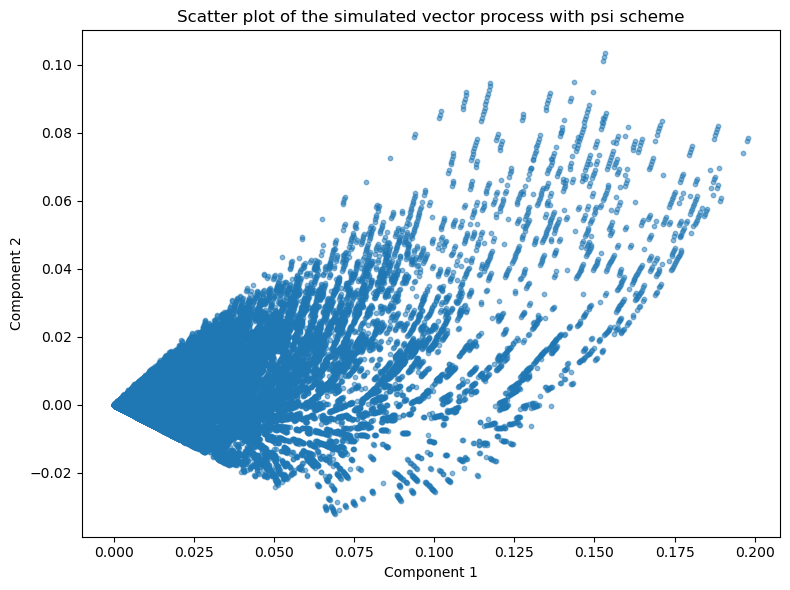

In [9]:
# Model parameters
a = 0.02
k = 0.3
sigma = 0.3
x0 = 0.0
T = 100
N = 10**5

rho = np.array([1, 10])
gamma = np.array([1, 2])
dim = len(rho)

# Instantiate CIR model
cir = CIRProcess(a, k, sigma, rho, gamma, x0, dim)

# Simulate a vector path using the psi scheme
psi_path = cir.simulate_multifactor(T, N, n_simulation=1)  # shape: (1, N+1, dim)
traj = psi_path[0]  # shape: (N+1, dim)

# Scatter plot (component 1 on x-axis, component 2 on y-axis)
plt.figure(figsize=(8, 6))
plt.scatter(traj[:, 0], traj[:, 1], s=10, alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of the simulated vector process with psi scheme')
plt.tight_layout()
plt.show()



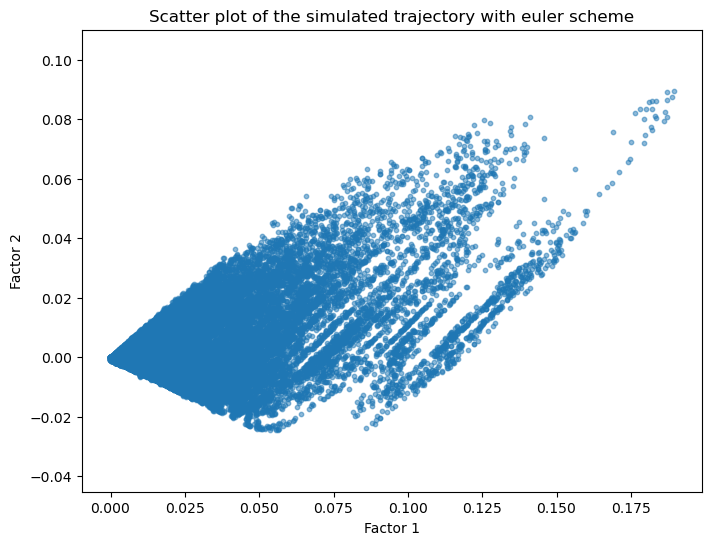

In [10]:
Y = cir.simulate_multifactor_euler(N=N, T=T, num_simulations=1)

traj = Y[:, 0, :]  # Extract the trajectory (shape: (N, dim))

# 2D scatter plot

plt.figure(figsize=(8, 6))
plt.scatter(traj[:, 0], traj[:, 1], s=10, alpha=0.5)
plt.title("Scatter plot of the simulated trajectory with euler scheme")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.axis('equal')
plt.show()


Now, we do a lot of simulations and plot in the plane the terminal points for both schemes.

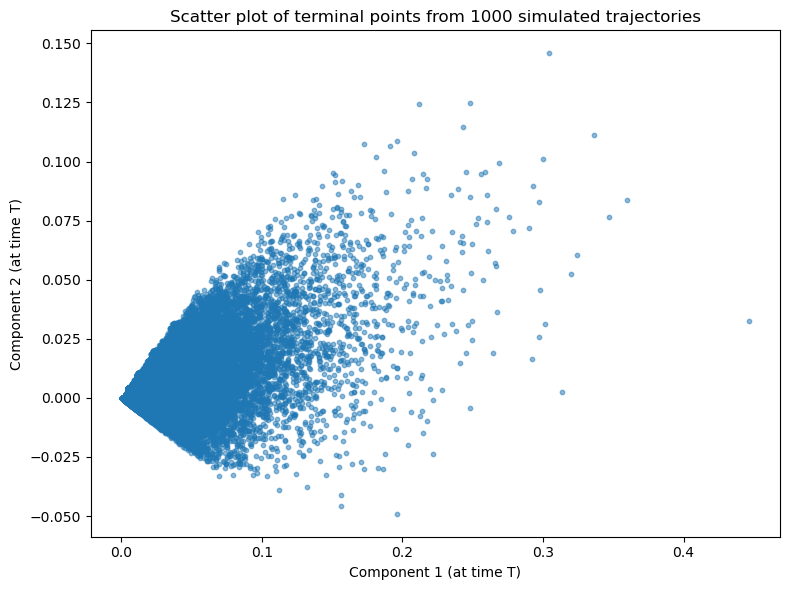

In [13]:
N = 10**4
# Simulate vector paths
n_simulation = 10**5
psi_paths = cir.simulate_multifactor(T, N, n_simulation=n_simulation)  

# Extract the terminal points (at time T) for each trajectory
terminal_points = psi_paths[:, -1, :] 

# Scatter plot of terminal points: component 1 vs component 2
plt.figure(figsize=(8, 6))
plt.scatter(terminal_points[:, 0], terminal_points[:, 1], s=10, alpha=0.5)
plt.xlabel('Component 1 (at time T)')
plt.ylabel('Component 2 (at time T)')
plt.title('Scatter plot of terminal points from 1000 simulated trajectories')
plt.tight_layout()
plt.show()


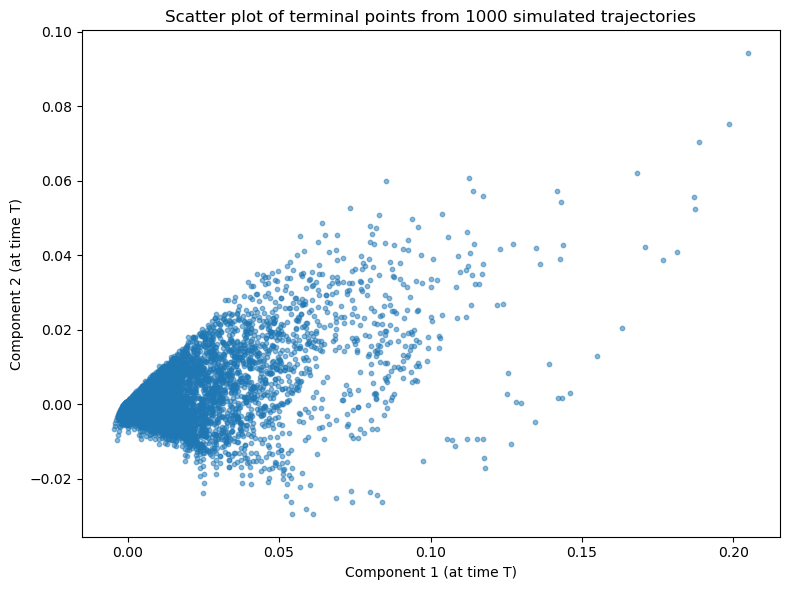

In [14]:
N = 10**4
# Simulate vector paths
n_simulation = 10**5
euler_paths = cir.simulate_multifactor_euler(N, T, num_simulations=n_simulation) 

# Extract the terminal points (at time T) for each trajectory
terminal_points = euler_paths[:, -1, :]  # shape: (1000, dim)

# Scatter plot of terminal points: component 1 vs component 2
plt.figure(figsize=(8, 6))
plt.scatter(terminal_points[:, 0], terminal_points[:, 1], s=10, alpha=0.5)
plt.xlabel('Component 1 (at time T)')
plt.ylabel('Component 2 (at time T)')
plt.title('Scatter plot of terminal points from 1000 simulated trajectories')
plt.tight_layout()
plt.show()

## Comparisons

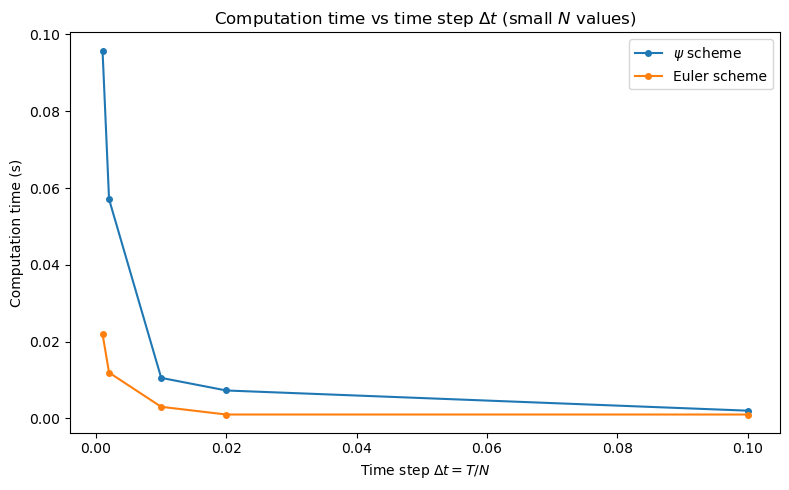

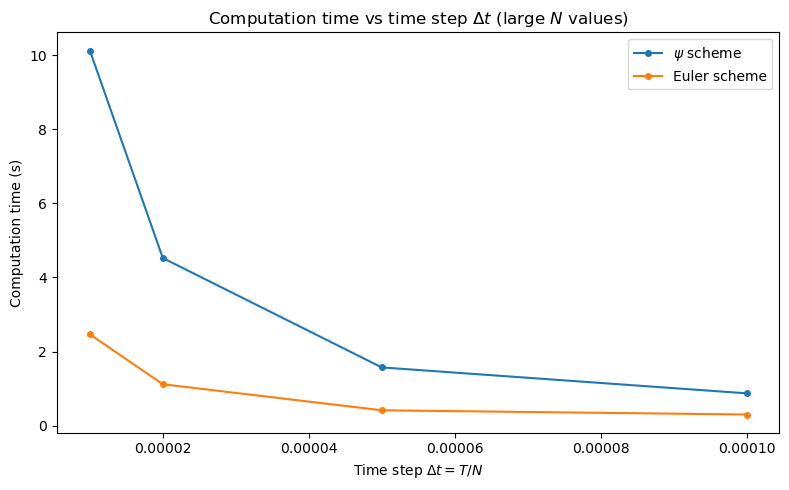

In [32]:
# Parameters
T = 1
n_simulation = 1

# Lists of N
N_values_small = [10, 50, 100, 500, 1000]
N_values_large = [10000, 20000, 50000, 100000]

# Convert to dt = T/N
dt_small = [T / N for N in N_values_small]
dt_large = [T / N for N in N_values_large]

times_psi_small = []
times_euler_small = []

times_psi_large = []
times_euler_large = []

# Timing for small N values
for N in N_values_small:
    start = time.time()
    _ = cir.simulate_multifactor(T, N, n_simulation=n_simulation)
    end = time.time()
    times_psi_small.append(end - start)
    
    start = time.time()
    _ = cir.simulate_multifactor_euler(N, T, num_simulations=n_simulation)
    end = time.time()
    times_euler_small.append(end - start)

# Timing for large N values
for N in N_values_large:
    start = time.time()
    _ = cir.simulate_multifactor(T, N, n_simulation=n_simulation)
    end = time.time()
    times_psi_large.append(end - start)
    
    start = time.time()
    _ = cir.simulate_multifactor_euler(N, T, num_simulations=n_simulation)
    end = time.time()
    times_euler_large.append(end - start)

# Plotting for small dt values
plt.figure(figsize=(8, 5))
plt.plot(dt_small, times_psi_small, label=r'$\psi$ scheme', marker='o', markersize=4)
plt.plot(dt_small, times_euler_small, label='Euler scheme', marker='o', markersize=4)
plt.xlabel(r'Time step $\Delta t = T/N$')
plt.ylabel('Computation time (s)')
plt.title(r'Computation time vs time step $\Delta t$ (small $N$ values)')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting for large dt values
plt.figure(figsize=(8, 5))
plt.plot(dt_large, times_psi_large, label=r'$\psi$ scheme', marker='o', markersize=4)
plt.plot(dt_large, times_euler_large, label='Euler scheme', marker='o', markersize=4)
plt.xlabel(r'Time step $\Delta t = T/N$')
plt.ylabel('Computation time (s)')
plt.title(r'Computation time vs time step $\Delta t$ (large $N$ values)')
plt.legend()
plt.tight_layout()
plt.show()


# Second order schemes for the multifactor Heston model

We repeat the job we just did, but this time for the Heston model. The Heston model is given by
$$dY_t = \left(r-\frac{1}{2} X_t \right) dt + \sqrt{X_t} \left( \rho dW_t + \sqrt{1-\rho^2} dW_t^\perp \right)$$
with $X_t = x_0 + \sum_{i=1}^N \gamma_i X_t^i$ and where the $X^i$ satisfy 
$$dX_t^i = - \rho_i X_t^i dt + (a-kX_t)dt + \sigma \sqrt{X_t}dW_t$$
We use a splitting method to simulate $X^i_t$. Let's denote by $\mathcal{L}$ the infinitesimal generator of the equation of dimension $n+1$ above. We use a splitting and write $\mathcal{L} = \mathcal{L}_1 + \mathcal{L}_2$ where $\mathcal{L}_1$ is the infinitesimal generator associated to the ODE
$$
\begin{cases}
d X^i_t = - \rho_i X_t^i dt \\
d Y_t = 0 
\end{cases}
$$ 
and $\mathcal{L}_2$ is associated to 
$$
\begin{cases}
d X_t^i = (a-kX_t)dt + \sigma \sqrt{X_t} d W_t \ \forall i \in [1,n] \ \ \text{with} \ \ X_t = x_0 + \sum_{i=1}^n \gamma_i X_t^i \\
d Y_t = (r-\frac{1}{2} X_t) dt + \sqrt{X_t} \left( \rho dW_t + \sqrt{1-\rho^2} d W_t^\top \right)
\end{cases}
$$
The ODE associated to $\mathcal{L}_1$ can be solved exactly and the solution is given by the scheme
$$\bar\psi_1((\textbf{x}, y), t) = (\psi_1 (\textbf{x}, t), y)$$

For the equation associated to $\mathcal{L}_2$, we use the scheme $\bar\psi_2$ given by Alfonsi.

The scheme we use for the multifactor Heston model is then
$$\bar\Psi ((\textbf{x},y), t, Z) = \bar\psi_1 (\bar\psi_2 (\bar\psi_1 ((\textbf{x}, y), t/2), t, Z) , t/2)$$

As before, we define a class to do simulations.

In [23]:
class HestonProcess:
    def __init__(self, a, k, sigma, rho, gamma, Rho, r, x0, S0, dim):
        self.a = a
        self.k = k
        self.sigma = sigma
        self.rho = rho
        self.gamma = gamma
        self.Rho = Rho
        self.r = r
        self.x0 = x0
        self.S0 = S0
        self.dim = dim
        self.G0 = sum(gamma)
        self.a_bar = a * self.G0
        self.k_bar = k * self.G0
        self.sigma_bar = sigma * self.G0

    def zeta(self, t, k):
        return (1 - np.exp(-k * t)) / k if k != 0 else t

    def w(self, u):
        # Vectorized version for array input
        u = np.asarray(u)
        res = np.zeros_like(u)
        res[u > 5 / 6] = np.sqrt(3)
        res[u <= 1 / 6] = -np.sqrt(3)
        # Others remain 0
        return res

    def u1(self, t, x):
        return x * np.exp(-self.k_bar * t) + self.a_bar * self.zeta(t, self.k_bar)

    def u2(self, t, x):
        term1 = self.u1(t, x) ** 2
        term2 = self.sigma_bar ** 2 * self.zeta(t, self.k_bar) * (
            self.a_bar * self.zeta(t, self.k_bar) / 2 + x * np.exp(-self.k_bar * t)
        )
        return term1 + term2

    def pi(self, t, x):
        res = 1 - self.u1(t, x) ** 2 / self.u2(t, x)
        return (1 - np.sqrt(res)) / 2

    def K2(self, t):
        if self.sigma_bar ** 2 > 4 * self.a_bar:
            term1 = (self.sigma_bar ** 2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            term2 = np.sqrt(
                np.exp(self.k_bar * t / 2) * (self.sigma_bar ** 2 / 4 - self.a_bar) * self.zeta(t / 2, self.k_bar)
            ) + self.sigma_bar * np.sqrt(3 * t) / 2
            return np.exp(self.k_bar * t / 2) * (term1 + term2 ** 2)
        else:
            return 0

    def phi(self, x, t, u):
        x = np.asarray(x)
        u = np.asarray(u)
        K2_val = self.K2(t)

        res = np.zeros_like(x)

        mask_ge = (x >= K2_val)
        mask_lt = ~mask_ge

        # Case: x >= K2_val
        if np.any(mask_ge):
            part1 = np.sqrt((self.a_bar - self.sigma_bar ** 2 / 4) * self.zeta(t / 2, self.k_bar) +
                            np.exp(-self.k_bar * t / 2) * x[mask_ge])
            part1 += self.sigma_bar * np.sqrt(t) * self.w(u[mask_ge]) / 2
            part1 = np.exp(-self.k_bar * t / 2) * (part1 ** 2)
            part1 += (self.a_bar - self.sigma_bar ** 2 / 4) * self.zeta(t / 2, self.k_bar)
            res[mask_ge] = part1

        # Case: x < K2_val
        if np.any(mask_lt):
            idx_lt = np.where(mask_lt)[0]
            x_lt = x[idx_lt]
            u_lt = u[idx_lt]
            p = self.pi(t, x_lt)
            mask_u_le_p = (u_lt <= p)

            # Case: u <= p
            if np.any(mask_u_le_p):
                idx_le = idx_lt[mask_u_le_p]
                res[idx_le] = self.u1(t, x[idx_le]) / (2 * p[mask_u_le_p])

            # Case: u > p
            if np.any(~mask_u_le_p):
                idx_gt = idx_lt[~mask_u_le_p]
                res[idx_gt] = self.u1(t, x[idx_gt]) / (2 * (1 - p[~mask_u_le_p]))

        return res

    def A(self, X, y, x0):
        x = x0
        for i in range(self.dim):
            x += self.gamma[i] * X[i]
        return X + (y - x) / self.G0

    def psi2(self, X, t, u, x0):
        x = x0
        for i in range(self.dim):
            x += self.gamma[i] * X[i]
        return self.A(X, self.phi(np.array([x]), t, u), x0)

    def psi1(self, X, t):
        return X * np.exp(-self.rho * t)

    def psi1_tilde(self, X, y, t):
        res1 = self.psi1(X, t)
        return res1, y

    def psi2_tilde(self, X, y, t, z):
        # X shape: (n_simulation, dim)
        # y shape: (n_simulation,)

        # Compute aggregated volatility x for each simulation
        x = self.x0 + np.dot(X, self.gamma)  # shape: (n_simulation,)

        # phi returns simulated x'
        x_prime = self.phi(x, t, z[0])  # shape: (n_simulation,)

        # New X result
        res1 = self.A(X.T, x_prime, self.x0).T  # transpose to match dimensions

        # New Y result
        res2 = y + (self.r - self.Rho * self.a / self.sigma) * t
        res2 += (self.Rho * self.k / self.sigma - 0.5) * (x + x_prime) * t / 2
        res2 += self.Rho * (x_prime - x) / self.sigma_bar
        res2 += np.sqrt(x + z[2] * (x_prime - x)) * np.sqrt(t * (1 - self.Rho ** 2)) * z[1]

        return res1, res2

    def psi_tilde(self, X, y, t, z):
        res11, res12 = self.psi1_tilde(X, y, t / 2)
        res21, res22 = self.psi2_tilde(res11, res12, t, z)
        res3 = self.psi1_tilde(res21, res22, t / 2)
        return res3

    def simulate_path(self, T, N, n_simulation=1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        dt = T / N
        X = np.zeros((N + 1, n_simulation, self.dim))
        Y = np.zeros((N + 1, n_simulation))

        # Initial condition
        Y[0, :] = np.log(self.S0)

        for i in range(N):
            # z0 ~ Uniform(0, 1)
            z0 = np.random.uniform(size=n_simulation)
            # z1 ~ Normal(0, 1)
            z1 = np.random.normal(size=n_simulation)
            # z2 ~ Bernoulli(0.5)
            z2 = np.random.binomial(1, 0.5, size=n_simulation)

            z = [z0, z1, z2]

            X_new, Y_new = self.psi_tilde(X[i], Y[i], dt, z)

            X[i + 1] = X_new
            Y[i + 1] = Y_new

        S = np.exp(Y)
        return X, Y, S

In [24]:
# Parameters
rho = np.array([0.06588906, 1.04979236, 1.78996945, 2.52111261, 3.24938890])
gamma = np.array([0.95998879, 0.06890172, 0.04257523, 0.03127181, 0.02488347])
S0 = 1
r = 0
Rho = -0.7
x0 = 0.02
a = 0.02
k = 0.3
sigma = 0.3
dim = 5

# Create the Heston process
heston = HestonProcess(a=a, k=k, sigma=sigma, rho=rho, gamma=gamma,
                       Rho=Rho, r=r, x0=x0, S0=S0, dim=dim)


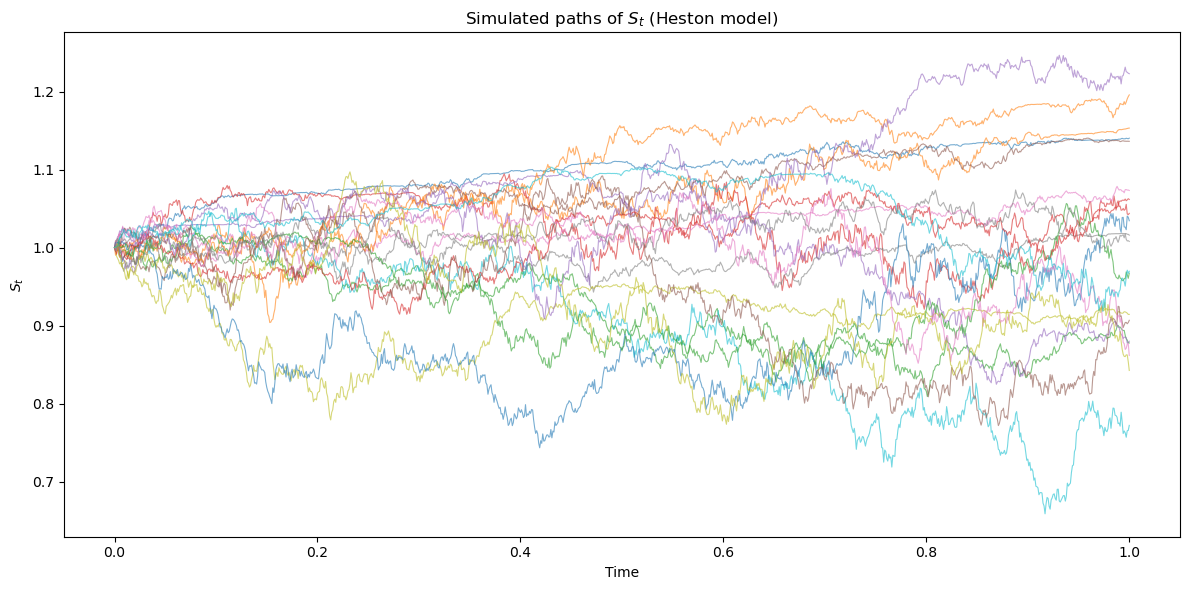

In [25]:
# Simulation parameters
T = 1.0       # 1-year maturity
N = 1000      # number of time steps
n_sim = 1000  # number of simulations

X, Y, S = heston.simulate_path(T, N, n_simulation=n_sim, seed=42)

time_grid = np.linspace(0, T, N + 1)

plt.figure(figsize=(12, 6))

# Plot a few sample paths
for i in range(20):
    plt.plot(time_grid, S[:, i], lw=0.8, alpha=0.6)

# Title and axes
plt.title("Simulated paths of $S_t$ (Heston model)")
plt.xlabel("Time")
plt.ylabel("$S_t$")
plt.tight_layout()
plt.show()


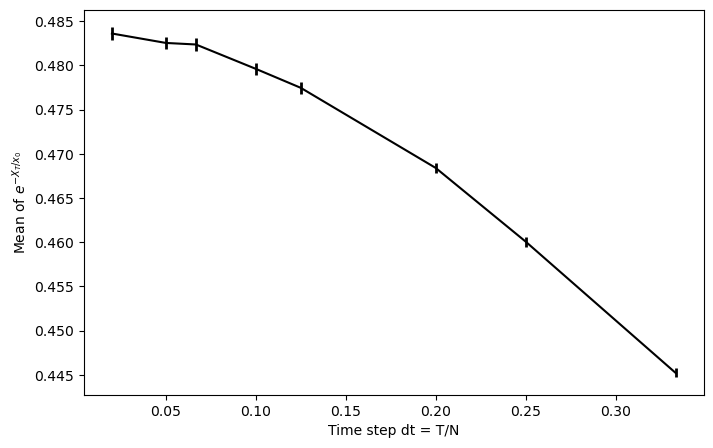

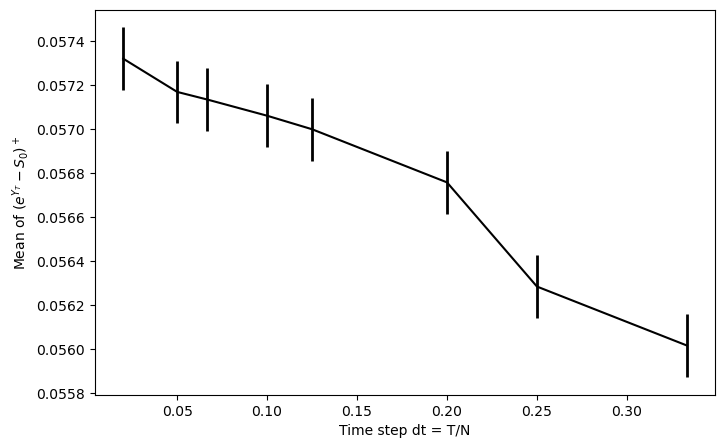

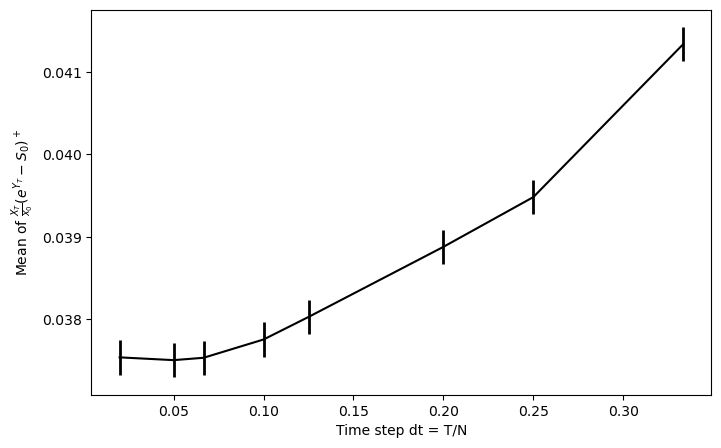

In [30]:
T = 1.0         # maturity 1 year
n_sim = 10**6   # number of simulations

N_values = [3, 4, 5, 8, 10, 15, 20, 50]

means_exp_negX = []
stds_exp_negX = []

means_call = []
stds_call = []

means_weighted_call = []
stds_weighted_call = []

for N in N_values:
    X, Y, S = heston.simulate_path(T, N, n_simulation=n_sim)
    X_T = X[-1]  # last time step (shape = (n_sim, dim))
    y_T = Y[-1]  # log S_T

    # Compute x = x0 + sum gamma_j * X_j
    x_vals = x0 + np.dot(X_T, gamma)

    # 1) e^{-X_T / x0}
    vals_exp_negX = np.exp(-x_vals / x0)
    means_exp_negX.append(np.mean(vals_exp_negX))
    stds_exp_negX.append(np.std(vals_exp_negX))

    # 2) (e^{Y_T} - S0)^+ (Call option payoff)
    call_payoff = np.maximum(np.exp(y_T) - S0, 0)
    means_call.append(np.mean(call_payoff))
    stds_call.append(np.std(call_payoff))

    # 3) (X_T / x0) * (e^{Y_T} - S0)^+ (Weighted call payoff)
    weighted_call = (x_vals / x0) * call_payoff
    means_weighted_call.append(np.mean(weighted_call))
    stds_weighted_call.append(np.std(weighted_call))

dt_values = T / np.array(N_values)

def plot_with_CI(x, means, stds, ylabel):
    ci = 1.96 * np.array(stds) / np.sqrt(n_sim)
    plt.figure(figsize=(8, 5))
    # No markers, no horizontal caps on error bars
    plt.errorbar(x, means, yerr=ci, fmt='none', ecolor='black', capsize=0, elinewidth=2)
    plt.plot(x, means, color='black')  # plot mean as a solid line
    plt.xlabel('Time step dt = T/N')
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.show()

plot_with_CI(dt_values, means_exp_negX, stds_exp_negX,
             r'Mean of $e^{-X_T/x_0}$')

plot_with_CI(dt_values, means_call, stds_call,
             r'Mean of $(e^{Y_T} - S_0)^+$')

plot_with_CI(dt_values, means_weighted_call, stds_weighted_call,
             r'Mean of $\frac{X_T}{x_0} (e^{Y_T} - S_0)^+$')



In dimension $2$, we can plot the coordoninates of $X$ in the plane.

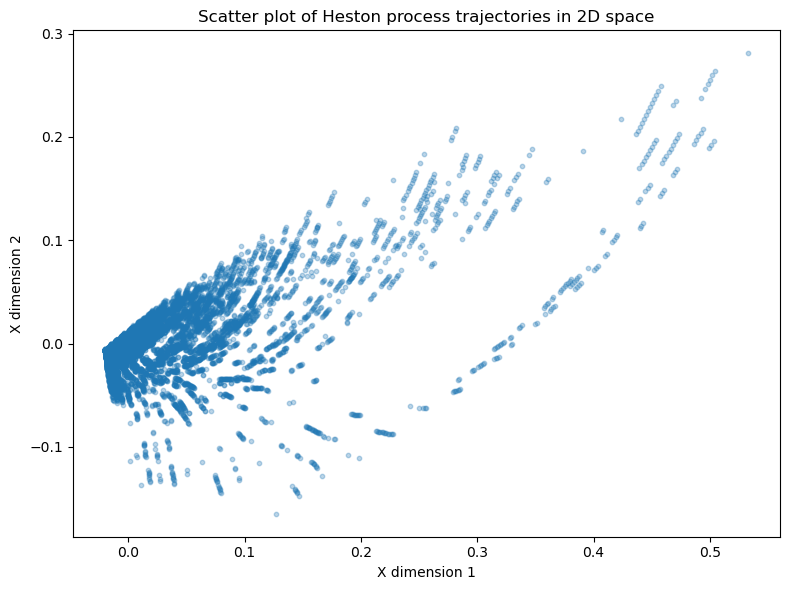

In [37]:
# Parameters
rho = np.array([0.06, 1.1])
gamma = np.array([0.9, 0.08])
S0 = 1
r = 0
Rho = -0.7
x0 = 0.02
a = 0.02
k = 0.3
sigma = 0.3
dim = 2


# Simulation parameters
T = 100       # 1-year maturity
N = 10000      # number of time steps
n_sim = 1  # number of simulations

X, Y, S = heston.simulate_path(T, N, n_simulation=n_sim, seed=42)

X_dim1 = X[:, :, 0].flatten()  # First dimension of X
X_dim2 = X[:, :, 1].flatten()  # Second dimension of X

plt.figure(figsize=(8, 6))
plt.scatter(X_dim1, X_dim2, alpha=0.3, s=10)

plt.xlabel('X dimension 1')
plt.ylabel('X dimension 2')
plt.title('Scatter plot of Heston process trajectories in 2D space')
plt.tight_layout()
plt.show()

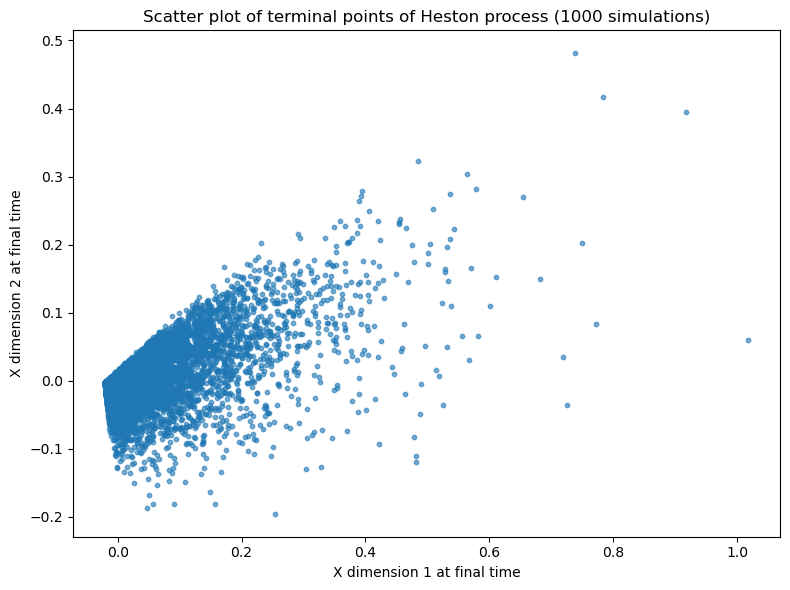

In [38]:
# Run the simulations
n_sim = 10**4
X, Y, S = heston.simulate_path(T, N, n_simulation=n_sim, seed=42)

# Extract the terminal points of X (at final time step N)
X_final_dim1 = X[-1, :, 0]  # Final time step, all simulations, dimension 1
X_final_dim2 = X[-1, :, 1]  # Final time step, all simulations, dimension 2

plt.figure(figsize=(8, 6))
plt.scatter(X_final_dim1, X_final_dim2, alpha=0.6, s=10)

plt.xlabel('X dimension 1 at final time')
plt.ylabel('X dimension 2 at final time')
plt.title('Scatter plot of terminal points of Heston process (1000 simulations)')
plt.tight_layout()
plt.show()